In [1]:
import os
import numpy as np
from pyhdf.SD import SD, SDC
import re
import datetime

# Location of your hdf files
folder = r"C:\Users\idine"

# Variable names in the hdf files
variables = [
    "Latitude", 
    "Longitude", 
    "mole_fraction_of_carbon_dioxide_in_free_troposphere"
]

# Extract date from filename
def get_date_from_filename(filename):
    date_str = re.findall(r'\d{4}\.\d{2}\.\d{2}', filename)[0]
    return datetime.datetime.strptime(date_str, "%Y.%m.%d")

# Get list of all hdf files in the folder
files = [f for f in os.listdir(folder) if f.endswith(".hdf")]

# Sort files by date
files.sort(key=get_date_from_filename)


# Initialize list to hold data and dates
data_list = []
date_list = []

# Loop through all sorted hdf files in the folder
for filename in files:
    file = os.path.join(folder, filename)
    
    # Open the hdf file
    hdf = SD(file, SDC.READ)
    
    # Temporarily store the variables
    temp_data = []
    
    # Loop through each variable and append the data to the corresponding list
    for var in variables:
        temp_data.append(hdf.select(var)[:])
    
    # Append temporary data to main list
    data_list.append(temp_data)
    
    # Get the date from the filename and convert to timestamp
    date = get_date_from_filename(filename)
    timestamp = date.timestamp()
    
    # Add timestamp to the date list
    date_list.append(timestamp)
    
    # Close the file
    hdf.end()

# Convert lists to numpy arrays
data_np = np.array(data_list)
date_np = np.array(date_list)

# Create a dictionary to store both arrays
data_dict = {"dates": date_np, "data": data_np}

In [3]:
np.set_printoptions(suppress=True)
print(data_np.shape)
latitudes = np.array(data_np[0][0])
longitudes = np.array(data_np[0][1])


(1646, 3, 91, 144)


In [4]:
# Because satellite don't see lower 
data_np = data_np[:, :, :76, :]

In [5]:
# Replace -9999 with np.nan
data_np[data_np == -9999] = None

In [78]:
# print(len(a), a)
# print(a)

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy import interpolate

In [8]:
target_var_index = 2

In [136]:
# Temporally interpolate for each latitude/longitude
for i in range(data_np.shape[2]):
    for j in range(data_np.shape[3]):
        valid_mask = np.isfinite(data_np[:, target_var_index, i, j])
        if np.any(valid_mask):
            interp_fn = interpolate.interp1d(np.flatnonzero(valid_mask), data_np[valid_mask, target_var_index, i, j], fill_value="extrapolate")
            data_np[:, target_var_index, i, j] = interp_fn(np.arange(data_np.shape[0]))
            
# Now, spatially interpolate for each day
for t in range(data_np.shape[0]):
    valid_mask = np.isfinite(data_np[t, target_var_index])
    if np.any(valid_mask):
        coords_known = np.column_stack(np.nonzero(valid_mask))
        values_known = data_np[t, target_var_index][valid_mask]
        coords_interp = np.column_stack(np.nonzero(~valid_mask))
        data_np[t, target_var_index][~valid_mask] = interpolate.griddata(coords_known, values_known, coords_interp, method='nearest')

data_np[:, 2, :, :][data_np[:, 2, :, :] < 0] = 0


In [138]:
# Assume that we are forecasting the 'mole_fraction_of_carbon_dioxide_in_free_troposphere' variable

target = data_np[:, target_var_index]
print(target[0])

[[0.00039398 0.00039398 0.0004073  ... 0.00039759 0.00039542 0.00039542]
 [0.00031991 0.00038629 0.0004073  ... 0.00038171 0.00043686 0.00053469]
 [0.00034418 0.00044011 0.00040369 ... 0.00038808 0.00035549 0.00051397]
 ...
 [0.00039434 0.00041211 0.0003878  ... 0.00038685 0.00038375 0.00038046]
 [0.00045443 0.00030801 0.00039489 ... 0.00033247 0.0003865  0.00038284]
 [0.00040069 0.00035866 0.00056521 ... 0.00038823 0.00041097 0.00036625]]


In [139]:
# Reshape for scaler
target = target.reshape(-1, 1)

# Normalize the target variable
scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler.fit_transform(target)
print(target_scaled)

[[0.20080385]
 [0.20080385]
 [0.20759332]
 ...
 [0.300252  ]
 [0.26791108]
 [0.19743435]]


In [140]:
# Return scaled data to original form
transformed_data = np.copy(data_np)
target_scaled_reshaped = target_scaled.reshape(data_np.shape[0], data_np.shape[2], data_np.shape[3])
transformed_data[:, target_var_index, :, :] = target_scaled_reshaped
print(transformed_data[0][0])

[[ 89.5  89.5  89.5 ...  89.5  89.5  89.5]
 [ 88.   88.   88.  ...  88.   88.   88. ]
 [ 86.   86.   86.  ...  86.   86.   86. ]
 ...
 [-56.  -56.  -56.  ... -56.  -56.  -56. ]
 [-58.  -58.  -58.  ... -58.  -58.  -58. ]
 [-60.  -60.  -60.  ... -60.  -60.  -60. ]]


In [141]:
# Define your longitude and latitude boundaries
lon_min, lon_max = 35, 85
lat_min, lat_max = 52, 65

In [142]:
from scipy import stats as st
# Combine latitudes and longitudes to 2D coordinates
coordinates = np.column_stack((latitudes.flatten(), longitudes.flatten()))

# Define the region boundaries
region = np.array([[lat_min, lon_min], [lat_max, lon_max]])

# Get the coordinates that fall within the region
region_mask = (coordinates[:, 0] >= region[0, 0]) & (coordinates[:, 0] <= region[1, 0]) & \
              (coordinates[:, 1] >= region[0, 1]) & (coordinates[:, 1] <= region[1, 1])

# Get the indices of these coordinates
region_indices = np.nonzero(region_mask)

# Reshape indices to the shape of latitude/longitude arrays
region_indices_reshaped = np.unravel_index(region_indices, latitudes.shape)

# Slice the data using these indices
transformed_data_sliced = transformed_data[:, target_var_index, region_indices_reshaped[0], region_indices_reshaped[1]]
# transformed_test_data_sliced = transformed_test_data[:, target_var_index, region_indices_reshaped[0], region_indices_reshaped[1]]
print(transformed_data_sliced[0].size)


147


In [143]:
data = []
for i in transformed_data_sliced:
    buf = i.flatten()
    data.append(buf)
data = np.array(data)
data = data.reshape(1646, 7, 21)

# NN

In [144]:
import torch

In [18]:
SHAPE = (1646, 7, 21)
N = SHAPE[0]

In [19]:
X = []
Y = []

for i in range(0, len(data)-7):
  X.append(data[i:i+7])
  Y.append(data[i+7:(i+1)+7])

In [20]:
print(X[0].shape)
print(Y[0].shape)

(7, 7, 21)
(1, 7, 21)


In [21]:
X_train, Y_train = X[:int(0.8*N)], Y[:int(0.8*N)]
X_test, Y_test = X[int(0.8*N):], Y[int(0.8*N):]

print(len(X_train), len(X_test))


1316 323


In [26]:
# Создание линейного преобразования
# Первый аргумент - это размерность входных данных
# Второй аргумент - это размерность выходных данных
linear = torch.nn.Linear(21*7, 21*7)
data_tensor = torch.tensor(data).float()
# Функция для выпрямления матрицы, нужно указать номер оси, начиная с которой нужно начать выпрямление
data_tensor = data_tensor.flatten(1)
print(data_tensor.shape)

torch.Size([1646, 147])


In [27]:
result = linear(data_tensor)
result.shape

torch.Size([1646, 147])

In [28]:
# Перевод данных в тензор типа float
data_tensor = torch.tensor(data).float()
data_tensor = data_tensor.flatten(1)
print(data_tensor.shape)

torch.Size([1646, 147])


In [208]:
# Многослойный перцептрон
model = torch.nn.Sequential(
          torch.nn.Linear(21*7, 512),
          torch.nn.LeakyReLU(0.1),
          torch.nn.Linear(512, 256),
          torch.nn.LeakyReLU(0.1),
          torch.nn.Linear(256, 21*7)
        )

In [209]:
# Функции активации: https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity
loss_func = torch.nn.MSELoss()

In [210]:
# https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

In [211]:
for epoch in range(10):
  epoch_loss_train = 0.
  epoch_loss_test = 0.

  # Обучение
  for x, y in zip(X_train, Y_train):

    # Переводим данные в тензор
    # и переводим их на память текущего устройства
    x = torch.tensor(x).float()
    y = torch.tensor(y).float()

    # Выпрямляем матрицу в вектор
    x = x.flatten(1)
    y = y.flatten(1)
    
    # Делаем предсказание
    y_pred = model(x)

    # Считаем ошибку с помощью функции потерь
    loss_value = loss_func(y_pred, y)

    # Считаем градиент функции потерь
    loss_value.backward()

    # Обновление весов модели
    optimizer.step()

    # Сохраняем значение ошибки на данном проходе
    epoch_loss_train += loss_value.item()
  
  # Валидация
  for x, y in zip(X_test, Y_test):

    # Переводим данные в тензор
    x = torch.tensor(x).float()
    y = torch.tensor(y).float()

    # Выпрямляем матрицу в вектор
    x = x.flatten(1)
    y = y.flatten(1)
    
    # Делаем предсказание
    y_pred = model(x)

    # Считаем ошибку с помощью функции потерь
    loss_value = loss_func(y_pred, y)

    # Сохраняем значение ошибки на данном проходе
    epoch_loss_test += loss_value.item()

  # Выводим средние значение ошибки
  print(epoch_loss_train/len(X_train), epoch_loss_test/len(X_test))

0.00679793791789887 0.0005813360792417702
0.0013600228062677297 0.0030211944304304734
0.0027562598610485446 0.0018749089860626267
0.0022963839037070336 0.0009657831635753593
0.0020342769524240713 0.0017577506446825924
0.001657458379046247 0.0013129442670498622
0.001379001851285253 0.0012620946984755097
0.00402654070880598 0.004830413713122755
0.005687388618006782 0.006778152169812595
0.003873140677472854 0.002028962457835629


In [212]:
# Изначальные данные
data_7 = torch.tensor(data[-7:]).float()
print(data_7.shape)
print(data_7.flatten(1).shape)
# Сколько дней нужно предсказать
days_to_predict = 4

result = []

for i in range(days_to_predict):

  # Выпрямляем матрицу в вектор
  data_7 = data_7.flatten(1)

  # Предсказываем следующий день
  next_day = model(data_7)
  print(next_day.shape)
  # Добавляем следующий день в батч
  data_7 = torch.concat([data_7[1:], next_day])
  
  # Сохраняем результат
  result.append(next_day)

torch.Size([7, 1, 7, 21])
torch.Size([7, 147])
torch.Size([7, 147])
torch.Size([13, 147])
torch.Size([25, 147])
torch.Size([49, 147])


In [213]:
print(len(result[0]))

7


In [214]:

numpy_array = [tensor.detach().numpy() for tensor in result]


final_array = np.array(numpy_array[0])

print(len(final_array))

7


In [215]:
print(len(data[-7:][0]))
print(data[-7:])

1
[[[[0.20616247 0.20537497 0.2044866  ... 0.20883684 0.20900011
    0.21490154]
   [0.20878609 0.20388019 0.20901419 ... 0.16719031 0.20937404
    0.20501629]
   [0.20563771 0.20757483 0.20771529 ... 0.21296015 0.2032533
    0.20770086]
   ...
   [0.20637508 0.20358433 0.20551322 ... 0.19963066 0.20353687
    0.20869485]
   [0.20695454 0.2066447  0.20446397 ... 0.2016585  0.20351656
    0.20690887]
   [0.20310241 0.2066768  0.20552085 ... 0.20067278 0.2055786
    0.20766726]]]


 [[[0.20714673 0.20482445 0.2046065  ... 0.205325   0.2077553
    0.2056967 ]
   [0.20913394 0.20381875 0.20781416 ... 0.16302826 0.20900206
    0.20192915]
   [0.20582157 0.20789517 0.20772725 ... 0.21023616 0.20412701
    0.20764996]
   ...
   [0.20622447 0.20345502 0.20513758 ... 0.1997246  0.20414309
    0.20913695]
   [0.20718694 0.20916149 0.20396154 ... 0.20070337 0.20349793
    0.2071467 ]
   [0.20221403 0.20653051 0.20369264 ... 0.19840217 0.20599964
    0.20731975]]]


 [[[0.20813099 0.20427392 0.204

In [41]:
# Создание первого массива (размером 90x143) с пустыми значениями
array1 = np.empty((90, 143))

# Создание второго массива (размером 7x21)
array2 = np.random.random((7, 21))

# Определение позиций для вставки второго массива
start_row = 13
end_row = start_row + array2.shape[0]
start_col = 86
end_col = start_col + array2.shape[1]

# Вставка второго массива в первый
array1[start_row:end_row, start_col:end_col] = array2

# Проверка результата
print(array1.shape)  # Размер первого массива
print(array1[13:20, 86:107])  # Вывод области, в которую был вставлен второй массив

(90, 143)
[[0.33829466 0.60861641 0.453209   0.5825506  0.68799691 0.29246786
  0.83791748 0.77554428 0.8176201  0.88978317 0.39913283 0.29985204
  0.82356746 0.90048157 0.17372938 0.50727019 0.81063904 0.86252555
  0.73871306 0.65483553 0.49554968]
 [0.82780532 0.51031253 0.19396691 0.26220893 0.53102424 0.14265822
  0.5454396  0.06121592 0.66475638 0.24227794 0.87871449 0.67358963
  0.4285232  0.04953412 0.68949508 0.0728156  0.25826479 0.12957636
  0.39458823 0.52786263 0.61938659]
 [0.24810853 0.29357405 0.3510494  0.08104208 0.98749478 0.87860775
  0.00082717 0.36888234 0.90700246 0.25921771 0.37901973 0.13416788
  0.38040004 0.47297134 0.49144078 0.57575509 0.26074925 0.81502603
  0.46601423 0.72177854 0.89581572]
 [0.13888612 0.6303976  0.17519924 0.84796203 0.98634649 0.2374088
  0.21035969 0.91030294 0.19586904 0.96176359 0.79811789 0.12713434
  0.6401857  0.26498064 0.35241922 0.48460396 0.98746136 0.45741827
  0.80786082 0.94893025 0.25648676]
 [0.87802448 0.58705593 0.67131

# CNN

In [443]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [452]:
# Двухслойная свёрточная сеть
model = torch.nn.Sequential(
          torch.nn.Conv2d(in_channels=1, out_channels=1,
                       kernel_size=(2,2), stride=1),
          torch.nn.Conv2d(in_channels=1, out_channels=1,
                       kernel_size=(3, 3), stride=1),
          torch.nn.Flatten(start_dim=1),
          torch.nn.Linear(72, 21*7)
        ).to(device)

In [453]:
data_o = data
data = data.squeeze()
data = np.expand_dims(data, 1)
N = data.shape[0]
data.shape

(1646, 1, 7, 21)

In [454]:
X = []
Y = []

for i in range(0, N-1):
  X.append(data[i])
  Y.append(data[i+1])

X = np.array(X)
Y = np.array(Y)

print(X.shape, Y.shape)

(1645, 1, 7, 21) (1645, 1, 7, 21)


In [455]:
# Разбиваем на test train
X_train, Y_train = X[:int(0.8*N)], Y[:int(0.8*N)]
X_test, Y_test = X[int(0.8*N):], Y[int(0.8*N):]

print(len(X_train), len(X_test))

1316 329


In [456]:
# создание загрузчика данных
train_dataloader = torch.utils.data.DataLoader(list(zip(X_train, Y_train)), batch_size=16)
test_dataloader = torch.utils.data.DataLoader(list(zip(X_test, Y_test)), batch_size=16)

In [457]:
for x, y in train_dataloader:
  break
x.shape

torch.Size([16, 1, 7, 21])

In [458]:
y.shape

torch.Size([16, 1, 7, 21])

In [464]:
# Функции активации: https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity
loss_func = torch.nn.MSELoss()
# https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

for epoch in range(10):
  epoch_loss_train = 0.
  epoch_loss_test = 0.

  # Обучение
  for x, y in train_dataloader:

    # Переводим данные на память текущего устройства
    x = x.to(device)
    y = y.to(device)
    
    # Делаем предсказание
    y_pred = model(x)
    
    # Считаем ошибку с помощью функции потерь
    loss_value = loss_func(y_pred, y.flatten(1))

    # Считаем градиент функции потерь
    loss_value.backward()

    # Обновление весов модели
    optimizer.step()

    # Сохраняем значение ошибки на данном проходе
    epoch_loss_train += loss_value.item()
  
  # Валидация
  for x, y in test_dataloader:

    # Переводим данные в тензор
    x = x.to(device)
    y = y.to(device)
    
    # Делаем предсказание
    y_pred = model(x)

    # Считаем ошибку с помощью функции потерь
    loss_value = loss_func(y_pred, y.flatten(1))

    # Сохраняем значение ошибки на данном проходе
    epoch_loss_test += loss_value.item()

  # Выводим средние значение ошибки
  print(epoch_loss_train/len(train_dataloader), epoch_loss_test/len(test_dataloader))

0.005102121944438262 0.0049243260485430556
0.0050310135190655665 0.004837448420446543
0.004991625906922013 0.004792617500892707
0.004968237838741526 0.00476410412894828
0.004971184206744993 0.004782566556795722
0.005023531812097293 0.004857610622864394
0.005117665751870856 0.0049684060560095875
0.005221330942249441 0.005072594553764377
0.005296763077557805 0.005136189450110708
0.005323337637875454 0.005141117122201692


In [506]:
# buf = torch.tensor(data[-2]).float()
# print(data[-2])
# a = model(buf)
# a.reshape(7, 21)
# data[-1].shape
# res = []

buf = torch.tensor(data[-1]).float()
days_to_predict = 5

for i in range(days_to_predict):
    buf = model(buf).reshape(1, 1, 7, 21)
    res.append(buf)
print(res[-1])
    
    
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

tensor([[[[0.2580, 0.2262, 0.2799, 0.1872, 0.2180, 0.2153, 0.1503, 0.2783,
           0.2787, 0.1900, 0.2055, 0.1522, 0.1664, 0.3147, 0.3079, 0.3485,
           0.1496, 0.2956, 0.1723, 0.1542, 0.2580],
          [0.1073, 0.2863, 0.1606, 0.1885, 0.1974, 0.3161, 0.3346, 0.1556,
           0.2136, 0.1698, 0.2918, 0.3246, 0.2143, 0.2161, 0.1424, 0.3170,
           0.2209, 0.1694, 0.3221, 0.2993, 0.2390],
          [0.3545, 0.1622, 0.1930, 0.2079, 0.3415, 0.1288, 0.1293, 0.1958,
           0.1186, 0.1274, 0.3485, 0.1932, 0.1835, 0.1580, 0.3602, 0.2109,
           0.3477, 0.1658, 0.2502, 0.2091, 0.1776],
          [0.2880, 0.1371, 0.2832, 0.2488, 0.1405, 0.2712, 0.2750, 0.2979,
           0.3105, 0.1894, 0.2165, 0.1934, 0.1425, 0.1395, 0.2337, 0.2906,
           0.2756, 0.2160, 0.3017, 0.2375, 0.2707],
          [0.3077, 0.1643, 0.1413, 0.2424, 0.2923, 0.1079, 0.1461, 0.1535,
           0.1745, 0.3790, 0.3587, 0.3467, 0.0917, 0.3737, 0.1080, 0.2586,
           0.2285, 0.2902, 0.3520, 0.1737,

# Prediction

In [198]:
pr_array = [tensor.detach().numpy() for tensor in a]
pr_array = pr_array[0].reshape(7, 21)
pr_array

array([[ 0.31752813,  0.24615242,  0.25093657,  0.23966391,  0.3456794 ,
         0.28015164,  0.32528874,  0.31215668,  0.36042833,  0.389701  ,
         0.36048496,  0.27494496,  0.1386469 ,  0.2596536 ,  0.30884382,
         0.3442869 ,  0.33479974,  0.37086487,  0.37928447,  0.29257414,
         0.2801813 ],
       [ 0.32451218,  0.26315787,  0.24791202,  0.3313803 ,  0.25262773,
         0.20685118,  0.31439865,  0.38392946,  0.28234187,  0.2778359 ,
         0.31320122,  0.31449953,  0.32528436,  0.26105103,  0.26645666,
         0.3603759 ,  0.2837448 ,  0.3913293 ,  0.27408645,  0.3791176 ,
         0.31347352],
       [ 0.33394945,  0.39477068,  0.39306843,  0.32958505,  0.32047957,
         0.2603019 ,  0.34593076,  0.38996845,  0.255     ,  0.27426165,
         0.26140666,  0.27602744,  0.38579813,  0.37264824,  0.23289046,
         0.3092758 ,  0.33542863,  0.26199004,  0.32615224,  0.3325632 ,
         0.3842612 ],
       [ 0.2343913 ,  0.3599643 ,  0.33356833, -0.10455978

In [199]:
# Inverse transform to get the original values
original_array = scaler.inverse_transform(pr_array.reshape(-1, 1))

# Reshape the original array back to its original shape
pr_array = np.reshape(original_array, pr_array.shape)
pr_array


array([[ 0.00062299,  0.00048295,  0.00049234,  0.00047022,  0.00067823,
         0.00054966,  0.00063822,  0.00061246,  0.00070717,  0.0007646 ,
         0.00070728,  0.00053945,  0.00027203,  0.00050944,  0.00060596,
         0.0006755 ,  0.00065688,  0.00072764,  0.00074416,  0.00057403,
         0.00054972],
       [ 0.0006367 ,  0.00051632,  0.00048641,  0.00065017,  0.00049566,
         0.00040585,  0.00061685,  0.00075328,  0.00055396,  0.00054512,
         0.00061451,  0.00061705,  0.00063821,  0.00051219,  0.00052279,
         0.00070706,  0.00055671,  0.00076779,  0.00053776,  0.00074383,
         0.00061504],
       [ 0.00065521,  0.00077455,  0.00077121,  0.00064665,  0.00062879,
         0.00051072,  0.00067872,  0.00076512,  0.00050031,  0.00053811,
         0.00051288,  0.00054157,  0.00075694,  0.00073114,  0.00045693,
         0.0006068 ,  0.00065812,  0.00051403,  0.00063992,  0.00065249,
         0.00075393],
       [ 0.00045988,  0.00070626,  0.00065447, -0.00020515

In [200]:
# Создание первого массива (размером 91x144) с пустыми значениями
array1 = np.full((91, 144), np.nan)

# Создание второго массива (размером 7x21)
array2 = pr_array

start_row = 12
end_row = 19
start_column = 86 
end_column = 107

array1[start_row:end_row, start_column:end_column] = array2
print(array1.shape)
print(array1[start_row:end_row, start_column:end_column].max)

(91, 144)
[[ 0.00062299  0.00048295  0.00049234  0.00047022  0.00067823  0.00054966
   0.00063822  0.00061246  0.00070717  0.0007646   0.00070728  0.00053945
   0.00027203  0.00050944  0.00060596  0.0006755   0.00065688  0.00072764
   0.00074416  0.00057403  0.00054972]
 [ 0.0006367   0.00051632  0.00048641  0.00065017  0.00049566  0.00040585
   0.00061685  0.00075328  0.00055396  0.00054512  0.00061451  0.00061705
   0.00063821  0.00051219  0.00052279  0.00070706  0.00055671  0.00076779
   0.00053776  0.00074383  0.00061504]
 [ 0.00065521  0.00077455  0.00077121  0.00064665  0.00062879  0.00051072
   0.00067872  0.00076512  0.00050031  0.00053811  0.00051288  0.00054157
   0.00075694  0.00073114  0.00045693  0.0006068   0.00065812  0.00051403
   0.00063992  0.00065249  0.00075393]
 [ 0.00045988  0.00070626  0.00065447 -0.00020515  0.00067075  0.00036738
   0.00070018  0.0006033   0.00052897  0.00068618  0.00069053  0.00074203
   0.0006491   0.00070969  0.00069818  0.0006832   0.000617

In [201]:
from pyhdf.SD import SD, SDC

hdf_file = SD(r'C:\Users\idine\Pred\1.hdf', SDC.WRITE | SDC.CREATE)
variable_index = 2  # Change this to the appropriate index or use variable name
dataset = hdf_file.select(variable_index)
your_array = np.array(array1, dtype=np.float32)
dataset[:, :] = your_array
hdf_file.end()

In [274]:
for x, y in train_dataloader:
  break
x.shape

torch.Size([16, 1, 7, 21])

In [336]:
# Двухслойная свёрточная сеть
model2 = torch.nn.Sequential(
          torch.nn.Conv2d(in_channels=1, out_channels=1,
                       kernel_size=(4, 4), stride=1),
          torch.nn.Conv2d(in_channels=1, out_channels=1,
                       kernel_size=(2,2), stride=1),
          torch.nn.Flatten(start_dim=1),
          torch.nn.Linear(51, 64),
          torch.nn.Linear(64, 21*7)
        ).to(device)

In [337]:
# Функции активации: https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity
loss_func2 = torch.nn.MSELoss()
# https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.0001)

for epoch in range(10):
  epoch_loss_train = 0.
  epoch_loss_test = 0.

  # Обучение
  for x, y in train_dataloader:

    # Переводим данные на память текущего устройства
    x = x.to(device)
    y = y.to(device)
    
    # Делаем предсказание
    y_pred = model2(x)
    
    # Считаем ошибку с помощью функции потерь
    loss_value = loss_func2(y_pred, y.flatten(1))

    # Считаем градиент функции потерь
    loss_value.backward()

    # Обновление весов модели
    optimizer2.step()

    # Сохраняем значение ошибки на данном проходе
    epoch_loss_train += loss_value.item()
  
  # Валидация
  for x, y in test_dataloader:

    # Переводим данные в тензор
    x = x.to(device)
    y = y.to(device)
    
    # Делаем предсказание
    y_pred = model2(x)

    # Считаем ошибку с помощью функции потерь
    loss_value = loss_func2(y_pred, y.flatten(1))

    # Сохраняем значение ошибки на данном проходе
    epoch_loss_test += loss_value.item()

  # Выводим средние значение ошибки
  print(epoch_loss_train/len(train_dataloader), epoch_loss_test/len(test_dataloader))

0.036689327109649957 0.017149832897952626
0.00910798827724823 0.005920827056148222
0.00551151989745986 0.00617770291864872
0.004476293161264564 0.0037732192847345558
0.003718946788302926 0.005890555347182921
0.0037427141347967357 0.007139918128294604
0.011502860073303154 0.01814079329016663
0.013431399206473795 0.02065325652559598
0.007582337692301406 0.005333354297493186
0.013218086677132151 0.022984603863386882


In [308]:
buf2 = torch.tensor(data[-2]).float()
print(model(buf))
a2 = model(buf)
a2.reshape(7, 21)
pr_array2 = [tensor.detach().numpy() for tensor in a]
pr_array2 = pr_array[0].reshape(7, 21)
# Inverse transform to get the original values
original_array2 = scaler.inverse_transform(pr_array.reshape(-1, 1))

# Reshape the original array back to its original shape
pr_array2 = np.reshape(original_array, pr_array.shape)
pr_array2


RuntimeError: mat1 and mat2 shapes cannot be multiplied (7x21 and 147x512)

0.007611702796610364 0.008222391607151144
0.010805635410080472 0.01273343623394058
0.01327500799783023 0.01228741148398036
0.01036674137148692 0.0072614384504656
0.00542179437309324 0.004623649819266228
0.006821801863520978 0.011467452027967997
0.016804349563836335 0.023336491946663176
0.02287733985717038 0.020272679981731233
0.010999273654656956 0.004218991646277053
0.0068769870993557825 0.01514503430752527

loss_func = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

0.05660708859024278 0.05494720772618339
0.050581237144139875 0.04898328813058989
0.04500743338322065 0.043634503902423946
0.03998961905578533 0.03878194359796388
0.03541731134236577 0.03431160038425809
0.03117571863155049 0.03011469684896015
0.027171191119824547 0.02611334409032549
0.02335875521761825 0.022298233228779975
0.01976783077670149 0.018731800661910148
0.016483427496649414 0.015514766176541647

1 2

.011859016016080796 0.007173443323976937
0.08379888351226832 0.0034895422092328468
0.18567820878261812 0.5802311329614549
0.3095384878050311 1.0969408523468744
0.3695627156734826 0.5071965995289031
0.39502059946577234 0.8577420966965812
1.0654165831405715 0.8656907706033616
0.4193625012076045 0.43931903157915386
3.3919475876602783 14.218680654253278
5.869964987488396 1.2100748107546853

2 2

0.036689327109649957 0.017149832897952626
0.00910798827724823 0.005920827056148222
0.00551151989745986 0.00617770291864872
0.004476293161264564 0.0037732192847345558
0.003718946788302926 0.005890555347182921
0.0037427141347967357 0.007139918128294604
0.011502860073303154 0.01814079329016663
0.013431399206473795 0.02065325652559598
0.007582337692301406 0.005333354297493186
0.013218086677132151 0.022984603863386882

In [342]:
array1_1 = [0.008222391607151144, 0.01273343623394058, 0.01228741148398036, 0.0072614384504656, 0.004623649819266228, 0.011467452027967997, 0.023336491946663176, 0.020272679981731233, 0.004218991646277053, 0.01514503430752527]
array2_1 = [0.05494720772618339, 0.04898328813058989, 0.043634503902423946, 0.03878194359796388, 0.03431160038425809, 0.03011469684896015, 0.02611334409032549, 0.022298233228779975, 0.018731800661910148,0.015514766176541647]
array1_2 = [0.007173443323976937, 0.0034895422092328468, 0.5802311329614549, 1.0969408523468744, 0.5071965995289031, 0.8577420966965812, 0.8656907706033616, 0.43931903157915386, 1.518680654253278, 1.2100748107546853]
array2_2 = [0.017149832897952626, 0.005920827056148222, 0.00617770291864872, 0.0037732192847345558, 0.005890555347182921, 0.007139918128294604, 0.01814079329016663, 0.02065325652559598, 0.005333354297493186, 0.022984603863386882]
x = [1, 2, 3, 4, 5, 6 , 7, 8, 9, 10]

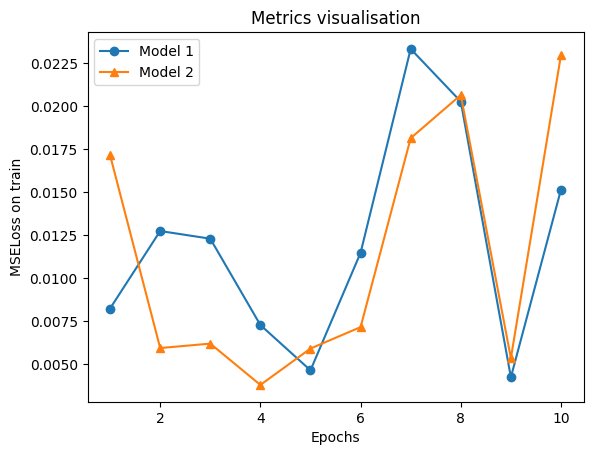

In [347]:
import matplotlib.pyplot as plt
# Set up the plot
plt.plot(x, array1_1, marker='o', label='Model 1')
# plt.plot(x, array2_1, marker='s', label='Dictionary 2')
# plt.plot(x, array1_2, marker='^', label='Dictionary 3')
plt.plot(x, array2_2, marker='^', label='Model 2')
# Display the plot
plt.xlabel('Epochs')
plt.ylabel('MSELoss on train')
plt.title('Metrics visualisation')
plt.legend()
plt.show()

In [350]:
scaler.inverse_transform([[0.063]])

array([[0.00012361]])

# RCNN

In [531]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
data = data.squeeze()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [532]:
X = []
Y = []

for i in range(0, N-7):
  X.append(data[i:i+7])
  Y.append(data[i+7:i+8])

X = np.array(X)
Y = np.array(Y)

X = np.expand_dims(X, 2)
Y = np.expand_dims(Y, 2)

# Разбиваем на test train
X_train, Y_train = X[:int(0.8*N)], Y[:int(0.8*N)]
X_test, Y_test = X[int(0.8*N):], Y[int(0.8*N):]

print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

(1316, 7, 1, 7, 21) (323, 7, 1, 7, 21)
(1316, 1, 1, 7, 21) (323, 1, 1, 7, 21)


In [533]:
class CRNN(nn.Module):
    def __init__(self):
        super(CRNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=2, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1)),
            nn.Conv2d(128, 128, kernel_size=2, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        
        self.rnn = nn.GRU(128, 256, bidirectional=False, num_layers=2, dropout=0.5)
        self.fc = nn.Linear(256 * 2, 7*21)
        
    def forward(self, x):
        # Shape of x: (batch_size, seq_length, channels, height, width)
        batch_size, seq_length, channels, height, width = x.size()
        x = x.view(batch_size * seq_length, channels, height, width)
        
        x = self.conv(x)
        x = x.squeeze(2)
        x = x.permute(2, 0, 1)
        _, hidden = self.rnn(x)
        hidden = hidden.permute(1, 0, 2).contiguous().view(-1, 256 * 2)
        output = self.fc(hidden)
        output = output.view(batch_size, seq_length, -1)
        return output[:, -1, :].reshape(-1, 1, 7, 21)  # Return prediction for the last day

In [534]:
# Создание загрузчика данных
train_dataloader = torch.utils.data.DataLoader(list(zip(X_train, Y_train)), batch_size=16)
test_dataloader = torch.utils.data.DataLoader(list(zip(X_test, Y_test)), batch_size=16)

In [535]:
for x, y in train_dataloader:
  break

x.shape, y.shape

(torch.Size([16, 7, 1, 7, 21]), torch.Size([16, 1, 1, 7, 21]))

In [536]:
# Создаем модель
model = CRNN()

In [537]:
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

# Кол-во эпох
n_epochs = 20

history = {
    'train_loss': [],
    'test_loss': []
}

for epoch in range(n_epochs):
  epoch_loss_train = 0.
  epoch_loss_test = 0.

  # Обучение
  for x, y in train_dataloader:

    # Переводим данные на память текущего устройства
    x = x.to(device)
    y = y.to(device)
    
    # Делаем предсказание
    y_pred = model(x)

    # Считаем ошибку с помощью функции потерь
    loss_value = loss_func(y_pred, y.flatten(1,2))

    # Считаем градиент функции потерь
    loss_value.backward()

    # Обновление весов модели
    optimizer.step()

    # Сохраняем значение ошибки на данном проходе
    epoch_loss_train += loss_value.item()
  
  # Валидация
  for x, y in test_dataloader:

    # Переводим данные в тензор
    x = x.to(device)
    y = y.to(device)
    
    # Делаем предсказание
    y_pred = model(x)

    # Считаем ошибку с помощью функции потерь
    loss_value = loss_func(y_pred, y.flatten(1, 2))

    # Сохраняем значение ошибки на данном проходе
    epoch_loss_test += loss_value.item()

  history['train_loss'].append(epoch_loss_train/len(train_dataloader))
  history['test_loss'].append(epoch_loss_test/len(test_dataloader))

  # Выводим средние значение ошибки
  print(history['train_loss'][-1], history['test_loss'][-1])

0.025098751461784165 0.007851728105119296
0.0043360997855394 0.003643564757935348
0.0033006700126072728 0.003006901015483198
0.0025058545211487145 0.002219058983471422
0.0017973202987607703 0.0015845286571198986
0.0015376009445368167 0.0015158222966073524
0.0014944687003202468 0.0015212531711551406
0.0014999348400946122 0.0012477151328875195
0.0019201303724233195 0.0015396566429574574
0.002610934730647244 0.0013850321660616568
0.004072348845292287 0.0044519576421451
0.004201995527949633 0.009167871792756375
0.004009950604480523 0.005545004559237333
0.008537448297467935 0.006212244630746898
0.0019484836578716983 0.0031683700092669043
0.006718938466139048 0.004301467688665504
0.0017618081204211675 0.002521483748707743
0.005029543628355107 0.00631842203438282
0.003551861365235983 0.0013586435455917602
0.0012262571274852716 0.0025179436363812003


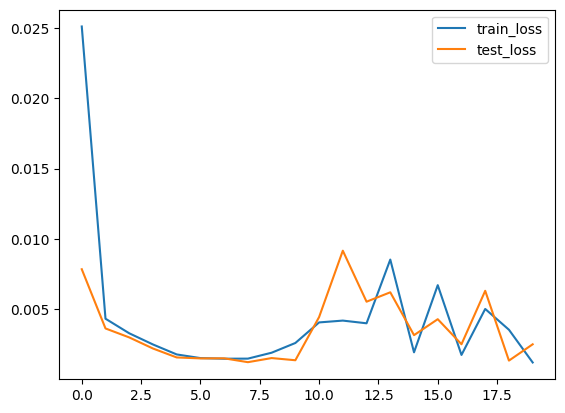

In [538]:
plt.plot(range(n_epochs), history['train_loss'])
plt.plot(range(n_epochs), history['test_loss'])
plt.legend(['train_loss', 'test_loss']);

# Predictions

In [539]:
def predict(input, model, days=1):
  input = input.unsqueeze(0)
  result = []
  for day in range(days):
    output = model(input)
    result.append(output)
    input = torch.cat([input[:,1:,:,:], output.reshape(1, 1, 1, 7, 21)], dim=1) 
  return torch.stack(result)

In [545]:
result = predict(x[0], model, days=365)
k = result

In [546]:
print(k)

tensor([[[[[0.2307, 0.2200, 0.2601,  ..., 0.2503, 0.2636, 0.1979],
           [0.2608, 0.2143, 0.1813,  ..., 0.2555, 0.2758, 0.2632],
           [0.2646, 0.1478, 0.2464,  ..., 0.2483, 0.2514, 0.2437],
           ...,
           [0.2386, 0.2222, 0.2360,  ..., 0.2046, 0.2700, 0.2110],
           [0.2330, 0.2823, 0.2246,  ..., 0.2427, 0.2740, 0.1981],
           [0.2827, 0.2578, 0.2322,  ..., 0.2572, 0.2483, 0.2778]]]],



        [[[[0.2342, 0.2314, 0.2825,  ..., 0.2924, 0.2676, 0.2226],
           [0.2989, 0.2341, 0.2209,  ..., 0.2532, 0.2812, 0.2668],
           [0.2813, 0.1887, 0.2723,  ..., 0.2393, 0.2622, 0.2506],
           ...,
           [0.2738, 0.2376, 0.2532,  ..., 0.2081, 0.2991, 0.2265],
           [0.2525, 0.3050, 0.2589,  ..., 0.2754, 0.2868, 0.2282],
           [0.3065, 0.2713, 0.2718,  ..., 0.2987, 0.2592, 0.2854]]]],



        [[[[0.2246, 0.2678, 0.3230,  ..., 0.3220, 0.2911, 0.2672],
           [0.3233, 0.2516, 0.2413,  ..., 0.2724, 0.2845, 0.3026],
           [0.3234